In [5]:
from pnet import pnet_loader, Pnet, PnetOG, ReactomeNetworkOG
from util import util, sankey_diag

import torch
import seaborn as sns
import pandas as pd
import numpy as np
import random
import pickle
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import os
import torch.nn.functional as F
import torch.nn as nn

%load_ext autoreload
%autoreload 2

Generate small test dataset

In [2]:
# rna_ext_val = pd.read_csv('/mnt/disks/pancan/data/mel_dfci_2019/data_RNA_Seq_expression_tpm_all_sample_Zscores.txt',
#                           delimiter='\t').set_index('Hugo_Symbol').T.drop('Entrez_Gene_Id').dropna(axis=1)
# cna_ext_val = pd.read_csv('/mnt/disks/pancan/data/mel_dfci_2019/data_CNA.txt',
#                           delimiter='\t').set_index('Hugo_Symbol').T.dropna(axis=1)
# ext_val = pd.read_csv('/mnt/disks/pancan/data/mel_dfci_2019/data_clinical_sample.txt',
#                              delimiter='\t').set_index('Sample Identifier').iloc[4:]
# important_genes = list(pd.read_csv('/mnt/disks/pancan/m1000/cancer_genes.txt')['genes'].values)
# joint_genes = list(set(important_genes).intersection(list(rna_ext_val.columns), list(cna_ext_val.columns)))
# gene_list = random.sample(joint_genes, 500)
# random_genes_a = list(rna_ext_val.sample(5, axis=1).columns)
# random_genes_b = list(cna_ext_val.sample(5, axis=1).columns)
# joint_samples = list(rna_ext_val.sample(20).join(cna_ext_val, rsuffix='_cna', how='inner').index)
# random_samples_a = list(rna_ext_val.sample(5, axis=0).index)
# random_samples_b = list(cna_ext_val.sample(5, axis=0).index)
# random_samples_c = list(cna_ext_val.sample(5, axis=0).index)
# random_samples_d = list(cna_ext_val.sample(5, axis=0).index)
# test_rna = rna_ext_val.loc[joint_samples+random_samples_a][joint_genes+random_genes_a].copy().drop_duplicates()
# test_cna = cna_ext_val.loc[joint_samples+random_samples_b][joint_genes+random_genes_b].copy().drop_duplicates()
# test_add = ext_val.loc[joint_samples+random_samples_c][['Purity', 'Ploidy']].copy().drop_duplicates()
# test_y = ext_val.loc[joint_samples+random_samples_d][['Heterogeneity']].copy().drop_duplicates()
# test_rna.reset_index(inplace=True)
# test_cna.reset_index(inplace=True)
# test_add.reset_index(inplace=True)
# test_y.reset_index(inplace=True)
# test_rna.rename(columns={'index': 'sample_id'}, inplace=True)
# test_cna.rename(columns={'index': 'sample_id'}, inplace=True)
# test_add.rename(columns={'Sample Identifier': 'sample_id'}, inplace=True)
# test_y.rename(columns={'Sample Identifier': 'sample_id'}, inplace=True)
# test_rna.to_csv('../data/test_data/rna.csv', index=False)
# test_cna.to_csv('../data/test_data/cna.csv', index=False)
# test_add.to_csv('../data/test_data/add.csv', index=False)
# test_y.to_csv('../data/test_data/y.csv', index=False)
# with open('../data/test_data/gene_sublist.txt', 'wb') as fp:
#     pickle.dump(gene_list, fp)

Read test data

In [3]:
test_rna = pd.read_csv('../data/test_data/rna.csv').set_index('sample_id')
test_cna = pd.read_csv('../data/test_data/cna.csv').set_index('sample_id')
test_add = pd.read_csv('../data/test_data/add.csv').set_index('sample_id')
test_y = pd.read_csv('../data/test_data/y.csv').set_index('sample_id')

with open('../data/test_data/gene_sublist.txt', 'rb') as fp:
    gene_list = pickle.load(fp)

In [4]:
genetic_data = {'rna': test_rna, 'cna': test_cna}

In [5]:
train_dataset, test_dataset = pnet_loader.generate_train_test(genetic_data,
                                                              test_y, 
                                                              additional_data=test_add,
                                                              test_split=0.2,
                                                              gene_set=gene_list,
                                                              collinear_features=2)

Given 2 Input modalities
Found 20 overlapping indicies
Initializing Train Dataset
Found 500 overlapping genes
generated input DataFrame of size (16, 1000)
Initializing Test Dataset
Found 500 overlapping genes
generated input DataFrame of size (4, 1000)
Replace input of: TRIM33_cna with collinear feature.
Replace input of: ZNF331_cna with collinear feature.


In [6]:
assert set(gene_list) == set(train_dataset.genes), 'Training dataset expected to have the same gene set as in file'
assert train_dataset.genes == list(train_dataset.input_df.columns)[:500], 'Training data genes should be ordered \
                                                                            as stored in the genes variable'
assert train_dataset.input_df.shape == torch.Size([16, 1000]), 'Input DataFrame expected to be a of size\
                                                        [16, 1000], got: {}'.format(train_dataset.input_df.shape)
assert train_dataset.x.shape == torch.Size([16, 1000]), 'Small train dataset expected to be a tensor of size\
                                                        [16, 1000], got: {}'.format(train_dataset.x.shape)
assert train_dataset.y.shape == torch.Size([16, 1]), 'Small train dataset expected to be a tensor of size\
                                                        [16, 1], got: {}'.format(train_dataset.y.shape)


In [7]:
train_loader, val_loader = pnet_loader.to_dataloader(train_dataset, test_dataset, 64)

In [8]:
test_y_bin = test_y.apply(lambda x: round(2*x)).astype(int)

In [9]:
canc_genes = list(pd.read_csv('../../pnet_database/genes/cancer_genes.txt').values.reshape(-1))

Task defined: BC 
 if this is not the intended task please specify task
Given 2 Input modalities
Found 20 overlapping indicies
Initializing Train Dataset
Found 649 overlapping genes
generated input DataFrame of size (16, 1298)
Initializing Test Dataset
Found 649 overlapping genes
generated input DataFrame of size (4, 1298)
Found 649 overlapping genes
We are sending to cuda
Epoch 1 of 10
Train Loss: 8.673269748687744
Test Loss: 16.386455535888672
Epoch 2 of 10
Train Loss: 8.720648050308228
Test Loss: 16.28811264038086
Epoch 3 of 10
Train Loss: 7.91260552406311
Test Loss: 16.1968936920166
Epoch 4 of 10
Train Loss: 7.0717689990997314
Test Loss: 16.095693588256836
Epoch 5 of 10
Train Loss: 7.364607810974121
Test Loss: 16.0058650970459
Epoch 6 of 10
Train Loss: 7.0273964405059814
Test Loss: 15.920306205749512
Epoch 7 of 10
Train Loss: 6.13792872428894
Test Loss: 15.840272903442383
Epoch 8 of 10
Train Loss: 6.226529836654663
Test Loss: 15.757250785827637
Epoch 9 of 10
Train Loss: 6.325377225

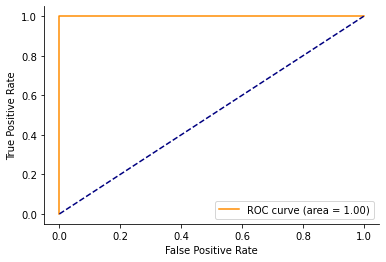

In [11]:
class_weights = util.get_class_weights(torch.tensor(test_y_bin.values).view(-1))
model, train_scores, test_scores, train_dataset, test_dataset = Pnet.run(genetic_data,
                                                                         test_y_bin,
                                                                         verbose=True,
                                                                         early_stopping=True,
                                                                         epochs=10,
                                                                         batch_size=10,
                                                                         loss_weight=class_weights,
                                                                         loss_fn=nn.BCEWithLogitsLoss(reduce=None),
                                                                         gene_set = canc_genes
                                                                        )

x_train = train_dataset.x
additional_train = train_dataset.additional
y_train = train_dataset.y
x_test = test_dataset.x
additional_test = test_dataset.additional
y_test = test_dataset.y

model.to('cpu')
pred, preds = model(x_test, additional_test)
y_pred_proba = model.predict_proba(x_test, additional_test).detach()
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
test_auc = metrics.roc_auc_score(y_test, y_pred_proba)
#create ROC curve
plt.plot(fpr,tpr, color="darkorange", label="ROC curve (area = %0.2f)" % test_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(loc="lower right")
plt.show()

In [12]:
model

PNET_NN(
  (loss_fn): BCEWithLogitsLoss()
  (layers): ModuleList(
    (0): PNET_Block(
      (gene_layer): Sequential(
        (0): CustomizedLinear(input_features=649, output_features=845, bias=True)
        (1): BatchNorm1d(845, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Tanh()
      )
      (pathway_layer): Sequential(
        (0): CustomizedLinear(input_features=734, output_features=845, bias=True)
        (1): BatchNorm1d(845, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Tanh()
        (3): Dropout(p=0.2, inplace=False)
      )
    )
    (1): PNET_Block(
      (gene_layer): Sequential(
        (0): CustomizedLinear(input_features=649, output_features=449, bias=True)
        (1): BatchNorm1d(449, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Tanh()
      )
      (pathway_layer): Sequential(
        (0): CustomizedLinear(input_features=845, output_features=449, bias=True)
        (1): Ba

Task defined: BC 
 if this is not the intended task please specify task
Given 2 Input modalities
Found 20 overlapping indicies
Initializing Train Dataset
Found 649 overlapping genes
generated input DataFrame of size (16, 1298)
Initializing Test Dataset
Found 649 overlapping genes
generated input DataFrame of size (4, 1298)
Found 649 overlapping genes
We are sending to cuda
Epoch 1 of 10
Train Loss: 3.273781418800354
Test Loss: 7.298801898956299
Epoch 2 of 10
Train Loss: 2.7470991611480713
Test Loss: 7.295413017272949
Epoch 3 of 10
Train Loss: 2.873022437095642
Test Loss: 7.292957305908203
Epoch 4 of 10
Train Loss: 2.185935378074646
Test Loss: 7.2942914962768555
Epoch 5 of 10
Train Loss: 2.229139804840088
Test Loss: 7.296471118927002
Epoch 6 of 10
Train Loss: 1.870430827140808
Test Loss: 7.298603534698486
Epoch 7 of 10
Train Loss: 1.574362576007843
Test Loss: 7.300767421722412
Epoch 8 of 10
Train Loss: 1.6623408198356628
Test Loss: 7.303244590759277
Epoch 9 of 10
Train Loss: 1.825820505

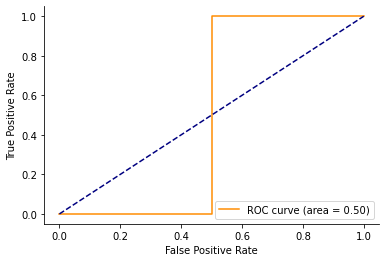

In [207]:
class_weights = util.get_class_weights(torch.tensor(test_y_bin.values).view(-1))
model, train_scores, test_scores, train_dataset, test_dataset = Pnet.run_geneset(genetic_data,
                                                                         test_y_bin,
                                                                        geneset_path='/mnt/disks/pancan/pnet/data/hallmark/c6.all.v2022.1.Hs.symbols.gmt',
                                                                         verbose=True,
                                                                         early_stopping=True,
                                                                         epochs=10,
                                                                         batch_size=10,
                                                                         loss_weight=class_weights,
                                                                         loss_fn=nn.BCEWithLogitsLoss(reduce=None),
                                                                         genes = canc_genes
                                                                        )

x_train = train_dataset.x
additional_train = train_dataset.additional
y_train = train_dataset.y
x_test = test_dataset.x
additional_test = test_dataset.additional
y_test = test_dataset.y

model.to('cpu')
pred, preds = model(x_test, additional_test)
y_pred_proba = model.predict_proba(x_test, additional_test).detach()
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
test_auc = metrics.roc_auc_score(y_test, y_pred_proba)
#create ROC curve
plt.plot(fpr,tpr, color="darkorange", label="ROC curve (area = %0.2f)" % test_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(loc="lower right")
plt.show()

In [208]:
model

PNET_NN(
  (loss_fn): BCEWithLogitsLoss()
  (layers): ModuleList(
    (0): PNET_Block(
      (gene_layer): Sequential(
        (0): CustomizedLinear(input_features=649, output_features=128, bias=True)
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Tanh()
      )
      (pathway_layer): Sequential(
        (0): CustomizedLinear(input_features=188, output_features=128, bias=True)
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Tanh()
        (3): Dropout(p=0.2, inplace=False)
      )
    )
    (1): PNET_Block(
      (gene_layer): Sequential(
        (0): CustomizedLinear(input_features=649, output_features=64, bias=True)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Tanh()
      )
      (pathway_layer): Sequential(
        (0): CustomizedLinear(input_features=128, output_features=64, bias=True)
        (1): Batch

In [204]:
import GenesetNetwork
gn = GenesetNetwork.GenesetNetwork(canc_genes, '/mnt/disks/pancan/pnet/data/hallmark/c6.all.v2022.1.Hs.symbols.gmt')

In [211]:
gn.pathway_encoding['ID'].nunique()

188

In [201]:
[l.shape for l in gn.gene_layers]

[(723, 188), (723, 128), (723, 64), (723, 32)]

In [202]:
[l.shape for l in gn.pathway_layers]

[(188, 128), (128, 64), (64, 32), (32, 1)]

In [205]:
gn.is_no_bugs()

True

In [203]:
gn.pathway_layers[0]

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
pathway,,,,,,,,,,,,,,,,,,,,,
AKT_UP.V1_DN,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
AKT_UP.V1_UP,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AKT_UP_MTOR_DN.V1_DN,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
AKT_UP_MTOR_DN.V1_UP,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ALK_DN.V1_DN,0,0,1,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WNT_UP.V1_DN,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
WNT_UP.V1_UP,0,0,1,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
YAP1_DN,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [107]:
gn.genes2pathways[gn.genes2pathways['gene'] == 'CCND2']

,pathway,gene
3,GLI1_UP.V1_UP,CCND2
166,CAMP_UP.V1_DN,CCND2
195,PRC1_BMI_UP.V1_UP,CCND2
200,PRC2_EED_DN.V1_UP,CCND2
606,E2F1_UP.V1_DN,CCND2
922,TBK1.DF_DN,CCND2
953,LEF1_UP.V1_UP,CCND2
1025,GCNP_SHH_UP_LATE.V1_UP,CCND2
1479,KRAS.KIDNEY_UP.V1_UP,CCND2


In [108]:
gn.genes2pathways.index.value_counts()

0       1
1170    1
1181    1
1180    1
1179    1
       ..
584     1
583     1
582     1
581     1
1760    1
Length: 1761, dtype: int64

In [109]:
gn.genes2pathways['gene']

0          RUNX1
1          ACSL6
2         SPECC1
3          CCND2
4         ZBTB16
          ...   
1756    TNFRSF14
1757       ARID2
1758     C2orf44
1759      TRIM33
1760       CEP89
Name: gene, Length: 1761, dtype: object

In [117]:
pd.get_dummies(gn.genes2pathways['gene']).join(gn.genes2pathways['pathway']).groupby('pathway').sum().T

pathway,AKT_UP.V1_DN,AKT_UP.V1_UP,AKT_UP_MTOR_DN.V1_DN,AKT_UP_MTOR_DN.V1_UP,ALK_DN.V1_DN,ALK_DN.V1_UP,ATF2_S_UP.V1_DN,ATF2_S_UP.V1_UP,ATF2_UP.V1_DN,ATF2_UP.V1_UP,...,TBK1.DN.48HRS_UP,TGFB_UP.V1_DN,TGFB_UP.V1_UP,VEGF_A_UP.V1_DN,VEGF_A_UP.V1_UP,WNT_UP.V1_DN,WNT_UP.V1_UP,YAP1_DN,YAP1_UP,residual
5-Sep,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6-Sep,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9-Sep,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
A1CF,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ABI1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNF429,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ZNF479,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
ZNF521,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
ZNRF3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df = pd.DataFrame(index=['train_loss', 'test_loss'], data=[train_scores, test_scores]).transpose()
df['auc'] = 0.75

In [ ]:
df

In [ ]:
task = util.get_task(test_y_bin)
target = util.format_target(test_y_bin, task)
train_dataset, test_dataset = pnet_loader.generate_train_test(genetic_data, target)
reactome_network = ReactomeNetwork.ReactomeNetwork(train_dataset.get_genes())

In [ ]:
model = Pnet.PNET_NN(reactome_network=reactome_network, task=task, nbr_gene_inputs=len(genetic_data),
                     loss_weight=class_weights, loss_fn=nn.BCEWithLogitsLoss(reduce=False))
train_loader, test_loader = pnet_loader.to_dataloader(train_dataset, test_dataset, 10)
model, train_scores, test_scores = Pnet.train(model, train_loader, test_loader, save_path='../results/model', epochs=10)

In [ ]:
def deeppathwayVAE_mask(gene_list, n_level=5):
    network = ReactomeNetworkOG.ReactomeNetwork(gene_list, n_levels=n_level)
    return network

In [78]:
ReactomeNetwork = deeppathwayVAE_mask(gene_list, n_level=5)

am I ever called?
Calculating graph....
Using all 28 nodes from the Reactome!
Extracting masks for all layers....
am I ever called?
(28, 1)
(160, 28)
(508, 160)
(1171, 508)
(1738, 1171)
(500, 1738)
Level |# Nodes
  1   |   [28]
  2   |   [160]
  3   |   [508]
  4   |   [1171]
  5   |   [1738]
The 0-th mask have shape (28, 1) with sparsity 0.0
The first mask have shape (160, 28) with sparsity 0.9640625
The second mask have shape (508, 160) with sparsity 0.99375
The third mask have shape (1171, 508) with sparsity 0.9980281339725788
The fourth mask have shape (1738, 1171) with sparsity 0.999142589566224
The fifth mask have shape (500, 1738) with sparsity 0.9968895281933257
99/500 genes are NOT connected to pathways!
909/1738 lowest level pathways are NOT connected to genes!
Done!


In [87]:
ReactomeNetwork.masks[-2].shape

(1738, 1171)

In [94]:
model.reactome_network.pathway_layers[0].shape

(734, 845)

In [101]:
canc_genes = list(pd.read_csv('../../pnet_database/genes/cancer_genes.txt').values.reshape(-1))